# CA4015 - Assignment 1 – Random Forest and AutoML

This assignment was carried out to better understand how machine learning models are trained using *Sci-kit learn* and the relative ease that this same task can be carried out using AutoML, such as the *PyCaret* library. 

The [Pima Indians diabetes](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database?select=diabetes.csv) dataset used for this assignment comes from Kaggle. To summarise the description on Kaggle, the objective of the dataset is to predict whenever a patient has diabetes or not from certain attributes provided in the dataset. All patients are female, over the age of 21 and of Pima Indiant heritage.

This assignment will be broken down into the following 4 sections:

### Section 1 - Setup and data preprocessing
- 1.1 - Importing packages
- 1.2 - Reading in the dataset
- 1.3 - Exploring the data
- 1.4 - Relating back to diabetes causes

### Section 2 - Creating a Random Forest
- 2.1 - Splitting data
- 2.2 - Default Random Forest
- 2.3 - Grid Search
- 2.4 - Boosting
- 2.5 - Results and comparison

### Section 3 - Using PyCaret
- 3.1 - Running model generation
- 3.2 - Results

### Section 4 - Conclusion
- 4.1 - Manual model creation vs. AutoML methods
---

### Section 1.1 - Importing packages

*RandomForestClassifier* - The random forest classifier.

*AdaBoostClassifier, GradientBoostingClassifier, DecisionTreeClassifier* - Boosting methods and decision tree to create a boosted random forest.

*cross_val_score* - Cross validation to test how generalizable a model is.

*train_test_split* - Split the data into a train and test set.

*GridSearchCV* - Grid search method to find the optimal parameters for a model.

*accuracy_score, confusion_matrix, classification_report* - Some functions for evaluation.

*pandas* - for dataframes and data wrangling.

*pycaret* - AutoML library for finding the ideal model for a machine learning problem.


In [1]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import pandas as pd
from pandas.plotting import scatter_matrix
from pycaret.classification import *

### Section 1.2 - Reading in the dataset

Using the Pandas read_csv function to load the dataset into a dataframe and inspect the columns and first 5 rows using head()

In [6]:
diabetes = pd.read_csv(r"C:\Users\adamt\notebooks\ca4015\diabetes.csv")# Change to the link to download to use directly
columns = diabetes.columns
print(diabetes.head())
print(columns)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


### Section 1.3 - Exploring the data

- info() - No values have nulls. There is a mix of integers and floats with regard to data types.

- describe() - There are definitely some outliers among various attributes such as Insulin and BMI as can be seen in the max row and looking at the distributions. These don't matter for a random forest however, so these don't need to be addressed or normalized.



In [7]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

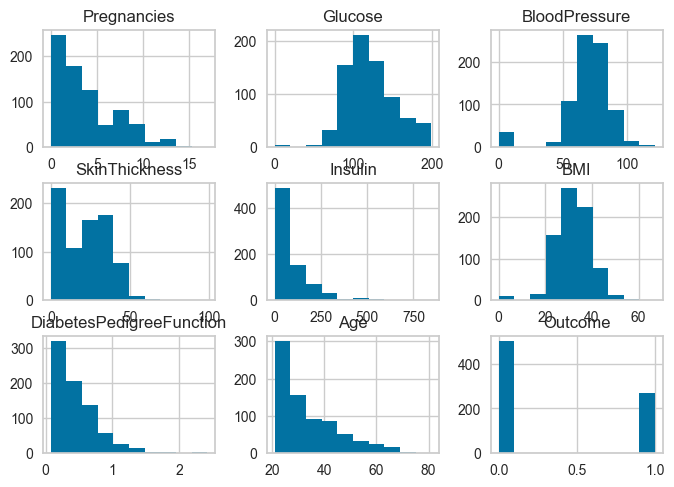

In [4]:
diabetes.hist()

### Section 1.4 - Relating back to diabetes causes

### Splitting data into a train and test set for manual model creation

In [ ]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

### Training a default decision tree

In [ ]:
clf = RandomForestClassifier()

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Understanding which features correlate with diabetes

The correlation between the different attributes and the otucome can be seen below.

Glucose concentration correlates with diabetes, which makes sense as insulin resistance puts pressure on the pancrease to make more insulin and eventually the demand for insulin can't be met and the glucose levels rise. So we know Glucose is an important feature.

BMI is also an important feature as a persons BMI being higher indicates they are closer to being overweight for their height. People who are not physically active or are overweight or even possibly obese can develop an insulin resistance.

Age is a factor as the older someone gets typically they become less active and develop an insulin resistance. Their pancreas may become less functional with age.

During pregnancy, women can get gestational diabetes due to the changes taking place in their body. This typically goes away after pregancy, but can increase the chance of getting type 2 diabetes later in life.

It seems skin thickness and blood pressure are not overly important attributes and can possibly be dropped.

In [ ]:
diabetes.corr()["Outcome"].sort_values(ascending=False)

In [ ]:
scatter_matrix(diabetes[diabetes.columns], figsize=(20,14))

In [ ]:
diabetes = diabetes.drop(["SkinThickness", "BloodPressure"], axis=1)

In [ ]:
diabetes.columns

### Feature enginerring

Testing out some combinations of the important attributes to see if there is any combination that makes an important attribute.

These new features are not very useful so we will drop them.

In [ ]:
tmp_diabetes = diabetes
tmp_diabetes["pregnancies_per_year"] = tmp_diabetes["Pregnancies"]/tmp_diabetes["Age"]
tmp_diabetes["glucose_per_bmi"] = tmp_diabetes["Glucose"]/tmp_diabetes["BMI"]
tmp_diabetes["bmi_per_age"] = tmp_diabetes["BMI"]/tmp_diabetes["Age"]

In [ ]:
tmp_diabetes.corr()["Outcome"].sort_values(ascending=False)

### Using grid search to pick optimal parameters (For the parameters I'm checking!)

I'm using GridSearch to find the best combination of attributes in the set od parameters I have definited.

From the list I provided it seems that the best combination is 
{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

scalar = StandardScaler()
scaled_values = scalar.fit_transform(x.values)
x_scaled = pd.DataFrame(scaled_values, index=x.index, columns=x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
params = [{"n_estimators": [100, 200], 
           "max_depth":[1, 2], 
           "min_samples_split": [2, 5, 10], 
           "min_samples_leaf": [1, 3, 5], 
           "max_leaf_nodes": [2, 4, 6], 
           "min_impurity_decrease": [0.0, 0.2, 0.4]}]
clf = RandomForestClassifier(random_state=42)

gs_rf = GridSearchCV(clf, params, scoring="accuracy", cv=5)
gs_rf.fit(X_train, y_train)

In [ ]:
gs_rf.best_params_

In [ ]:
gs_rf

In [ ]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4), random_state=42, n_estimators=55, algorithm="SAMME.R", learning_rate=0.1)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=55, criterion='friedman_mse',  max_depth=2, random_state=42, max_leaf_nodes=4)
gbc_clf.fit(X_train, y_train)
y_pred = gbc_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

### Feature enginerring

Testing out some combinations of the important attributes to see if there is any combination that makes an important attribute.

These new features are not very useful so we will drop them.

In [51]:
tmp_diabetes = diabetes
tmp_diabetes["pregnancies_per_year"] = tmp_diabetes["Pregnancies"]/tmp_diabetes["Age"]
tmp_diabetes["glucose_per_bmi"] = tmp_diabetes["Glucose"]/tmp_diabetes["BMI"]
tmp_diabetes["bmi_per_age"] = tmp_diabetes["BMI"]/tmp_diabetes["Age"]

In [52]:
tmp_diabetes.corr()["Outcome"].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.466581
BMI                         0.292695
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
glucose_per_bmi             0.170972
pregnancies_per_year        0.163744
Insulin                     0.130548
SkinThickness               0.074752
BloodPressure               0.065068
bmi_per_age                -0.029840
Name: Outcome, dtype: float64

### Using grid search to pick optimal parameters (For the parameters I'm checking!)

I'm using GridSearch to find the best combination of attributes in the set od parameters I have definited.

From the list I provided it seems that the best combination is 
{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [165]:
x = diabetes.drop("Outcome", axis=1)
y = diabetes.Outcome

scalar = StandardScaler()
scaled_values = scalar.fit_transform(x.values)
x_scaled = pd.DataFrame(scaled_values, index=x.index, columns=x.columns)

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [166]:
params = [{"n_estimators": [100, 200], 
           "max_depth":[1, 2], 
           "min_samples_split": [2, 5, 10], 
           "min_samples_leaf": [1, 3, 5], 
           "max_leaf_nodes": [2, 4, 6], 
           "min_impurity_decrease": [0.0, 0.2, 0.4]}]
clf = RandomForestClassifier(random_state=42)

gs_rf = GridSearchCV(clf, params, scoring="accuracy", cv=5)
gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=42,
                                  

In [167]:
gs_rf.best_params_

{'max_depth': 2,
 'max_leaf_nodes': 4,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
gs_rf

In [177]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2, max_leaf_nodes=4), random_state=42, n_estimators=55, algorithm="SAMME.R", learning_rate=0.1)
ada_clf.fit(X_train, y_train)
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7597402597402597
[[86 14]
 [23 31]]
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       100
           1       0.69      0.57      0.63        54

    accuracy                           0.76       154
   macro avg       0.74      0.72      0.72       154
weighted avg       0.75      0.76      0.75       154



In [180]:
gbc_clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=55, criterion='friedman_mse',  max_depth=2, random_state=42, max_leaf_nodes=4)
gbc_clf.fit(X_train, y_train)
y_pred = gbc_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.7337662337662337
[[83 17]
 [24 30]]
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       100
           1       0.64      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.70       154
weighted avg       0.73      0.73      0.73       154



In [9]:
scores = cross_val_score(clf, x, y, cv=5)
print(scores)

[0.74025974 0.74675325 0.74675325 0.75816993 0.75816993]


In [10]:
scores = cross_val_score(ada_clf, x, y, cv=5)
print(scores)

[0.70779221 0.67532468 0.72077922 0.79738562 0.69934641]


In [13]:
exp_name = setup(diabetes, target="Outcome")

,Description,Value
0,session_id,5919
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(768, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7690,0.8050,0.5576,0.6929,0.6132,0.4531,0.4609,0.0410
rf,Random Forest Classifier,0.7690,0.8174,0.5360,0.7121,0.6011,0.4462,0.4616,0.0550
ridge,Ridge Classifier,0.7541,0.0000,0.5076,0.6814,0.5744,0.4091,0.4216,0.0040
lda,Linear Discriminant Analysis,0.7522,0.8002,0.5132,0.6723,0.5755,0.4073,0.4181,0.0050
lightgbm,Light Gradient Boosting Machine,0.7504,0.8220,0.5959,0.6477,0.6134,0.4310,0.4372,0.0110
gbc,Gradient Boosting Classifier,0.7411,0.8131,0.5526,0.6281,0.5828,0.3981,0.4032,0.0270
et,Extra Trees Classifier,0.7337,0.7863,0.4316,0.6563,0.5131,0.3446,0.3621,0.0600
knn,K Neighbors Classifier,0.7298,0.7473,0.5196,0.6187,0.5583,0.3682,0.3750,0.0080
ada,Ada Boost Classifier,0.7262,0.7820,0.5251,0.6145,0.5559,0.3626,0.3720,0.0230
dt,Decision Tree Classifier,0.6962,0.6570,0.5363,0.5575,0.5416,0.3160,0.3196,0.0040
